In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [3]:
from read_results import read_varnames
import saprc99_code.kpp4py as kpp

In [4]:
nvar = 74
varnames = read_varnames("saprc99_code/saprc99_Parameters.f90")[0:nvar]
print(varnames)

['H2SO4', 'HCOOH', 'CCO_OH', 'RCO_OH', 'CCO_OOH', 'RCO_OOH', 'XN', 'XC', 'SO2', 'O1D', 'ALK1', 'BACL', 'PAN', 'PAN2', 'PBZN', 'MA_PAN', 'H2O2', 'N2O5', 'HONO', 'ALK2', 'ALK3', 'TBU_O', 'ALK5', 'ARO2', 'HNO4', 'COOH', 'HOCOO', 'BZNO2_O', 'MEOH', 'ALK4', 'ARO1', 'DCB2', 'DCB3', 'CRES', 'DCB1', 'NPHE', 'ROOH', 'BALD', 'PHEN', 'CO', 'MGLY', 'ACET', 'HNO3', 'ETHENE', 'GLY', 'BZ_O', 'ISOPRENE', 'R2O2', 'TERP', 'METHACRO', 'OLE1', 'ISOPROD', 'OLE2', 'MVK', 'CCHO', 'HCHO', 'RNO3', 'O3P', 'RCHO', 'MEK', 'PROD2', 'O3', 'HO2', 'RO2_N', 'MA_RCO3', 'C_O2', 'BZCO_O2', 'RO2_R', 'NO', 'NO2', 'NO3', 'CCO_O2', 'RCO_O2', 'OH']


In [5]:
df_range = pd.read_csv('saprc99_range.csv', index_col=0)
df_range.head(10)

,min,max
H2SO4,2.131631e+10,1.223799e+12
HCOOH,1.941420e+10,1.137429e+11
CCO_OH,2.994973e+10,2.073705e+12
RCO_OH,1.275993e+10,1.380322e+12
CCO_OOH,8.695723e+05,1.215977e+12
RCO_OOH,4.160388e+05,7.387218e+11
XN,5.950410e+07,2.010207e+11
XC,4.906034e+12,5.593960e+12
SO2,8.404868e+05,1.202484e+12
O1D,1.000000e-08,7.012137e-01


# Make training data

In [67]:
y0_list = np.random.uniform(np.append(df_range['min'], 0), 
                            np.append(df_range['max'], 1), 
                            size=(20000, 75) )
y0_list.shape

(20000, 75)

In [68]:
%time y1_list = kpp.onestep(y0_list.T).T
y1_list.shape

CPU times: user 19.9 s, sys: 0 ns, total: 19.9 s
Wall time: 19.8 s


(20000, 74)

# Normalize data

In [70]:
normalizer = StandardScaler()
normalizer.fit(y0_list[:,0:74])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [71]:
X_train = np.append(normalizer.transform(y0_list[:,0:74]), 
                    y0_list[:,-1:], 
                    axis=1)
X_train.shape

(20000, 75)

In [72]:
Y_train = normalizer.transform(y1_list)
Y_train.std(axis=0)

array([1.00024652, 1.00407032, 1.00001701, 1.00004065, 1.00006436,
       1.00003095, 1.0872505 , 1.06401305, 0.98025695, 0.95709838,
       0.99459269, 1.05360971, 0.89600825, 0.93599234, 0.97790525,
       1.4218549 , 0.95597049, 9.6868089 , 0.45173257, 0.97870279,
       0.95461266, 0.94119602, 0.8581129 , 0.72196104, 0.93720335,
       0.89543236, 0.87912971, 5.75577018, 0.98102644, 0.92175838,
       0.89616886, 0.87243578, 1.17658794, 0.28446253, 0.65781135,
       1.04122014, 0.83750575, 0.77014355, 0.36375301, 0.99735318,
       0.76209767, 0.99741121, 1.01529148, 0.83831915, 0.76581481,
       1.19610251, 0.25904839, 0.72194585, 0.08994937, 0.67287792,
       0.58149668, 0.54535704, 0.17235807, 0.86412128, 0.78245858,
       0.78451379, 0.93312307, 0.78011536, 0.7584352 , 0.9765733 ,
       0.86350607, 0.94219374, 0.79806761, 0.83055996, 1.55439011,
       0.37438878, 0.60022889, 0.57646437, 0.15917632, 1.04466551,
       0.38291431, 0.34053617, 0.24114087, 0.18031412])

# Fit ANN

In [103]:
x_torch = Variable(torch.from_numpy(X_train).type(torch.FloatTensor).cuda())
y_torch = Variable(torch.from_numpy(Y_train).type(torch.FloatTensor).cuda())

In [104]:
H1, H2 = 500, 500

model = torch.nn.Sequential(
    torch.nn.Linear(75, H1),
    torch.nn.ReLU(),
    #torch.nn.Tanh(),
    #torch.nn.BatchNorm1d(H1),
    torch.nn.Linear(H1, H2),
    torch.nn.ReLU(),
    #torch.nn.Tanh(),
    #torch.nn.BatchNorm1d(H2),
    torch.nn.Linear(H2, 74)
).cuda()

In [105]:
loss_fn = torch.nn.MSELoss()

#optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)

for t in range(2000):
    
    def closure():
        optimizer.zero_grad()
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        loss.backward()
        return loss
    optimizer.step(closure)
    
    if (t+1)%200==0:
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        print(t+1, loss.data[0])

200 0.1013992428779602
400 0.05018558353185654
600 0.03691977262496948
800 0.025870271027088165
1000 0.02117454819381237
1200 0.01806717738509178
1400 0.01652977243065834
1600 0.014237845316529274
1800 0.013693823479115963
2000 0.011524293571710587


In [106]:
%%time 
y_pred = model(x_torch)
y_pred_numpy = y_pred.data.cpu().numpy()

CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 12 ms


In [107]:
r2_score(y_pred_numpy, Y_train)

0.9592634049344905

(-20, 20)

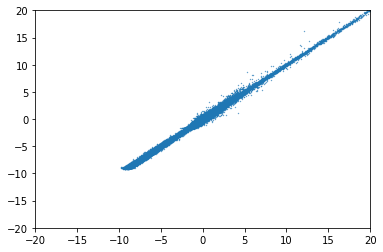

In [108]:
plt.scatter(y_pred_numpy.ravel(), Y_train.ravel(), s=0.1)
plt.xlim(-20,20)
plt.ylim(-20,20)

# Test set

In [109]:
y0_test = np.random.uniform(np.append(df_range['min'], 0), 
                            np.append(df_range['max'], 1), 
                            size=(5000, 75) )
y0_list.shape

(20000, 75)

In [110]:
%time y1_test = kpp.onestep(y0_test.T).T

CPU times: user 4.96 s, sys: 0 ns, total: 4.96 s
Wall time: 4.93 s


In [111]:
X_test = np.append(normalizer.transform(y0_test[:,0:74]), 
                   y0_test[:,-1:], 
                   axis=1)
Y_test = normalizer.transform(y1_test)

In [112]:
%%time
X_torch_test = Variable(torch.from_numpy(X_test).type(torch.FloatTensor).cuda())
y_test_pred = model(X_torch_test).data.cpu().numpy()

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 5.4 ms


In [113]:
r2_score(y_test_pred, Y_test)

0.9032142397622854

(-20, 20)

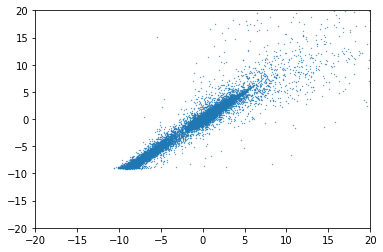

In [114]:
plt.scatter(y_test_pred, Y_test, s=0.1)
plt.xlim(-20,20)
plt.ylim(-20,20)

(-20, 20)

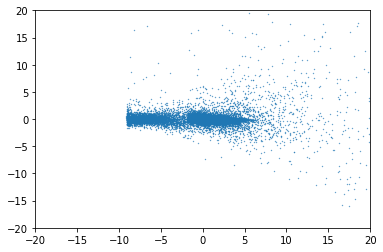

In [115]:
plt.scatter(Y_test, y_test_pred-Y_test, s=0.1)
plt.xlim(-20,20)
plt.ylim(-20,20)